# Introducción del proyecto

Nuestro cliente Interconnect, quien se dedica a ofrecer servicios de telecomunicaciones, le gustaría poder pronosticar su tasa de cancelación de clientes. Y nos ha solicitado que diseñemos un modelo de aprendizaje automático que prediga cuando un usuario o usuaria planea irse. Lo anterior con el fin de ofrecerle a dichos clientes códigos promocionales y opciones de planes especiales para buscar retenerlos. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de los clientes, incluyendo información sobre sus planes y contratos. Toda esta información se nos ha compartido y será tratada con total confidencialidad.

# Carga de librerías

In [ ]:
# En esta celda vamos a cargar todas las librerías necesarias para el proyecto.
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Carga de los datos

In [ ]:
# Cargamos los datos compartidos por nuestro cliente y creamos dataframes para poder observar y trabajar con los mismos.
contract_info = pd.read_csv('/datasets/final_provider/contract.csv', na_values=['', ' ', 'N/A', 'na', 'null'])
customer_info = pd.read_csv('/datasets/final_provider/personal.csv', na_values=['', ' ', 'N/A', 'na', 'null'])
internet_services = pd.read_csv('/datasets/final_provider/internet.csv', na_values=['', ' ', 'N/A', 'na', 'null'])
phone_services = pd.read_csv('/datasets/final_provider/phone.csv', na_values=['', ' ', 'N/A', 'na', 'null'])

# Análisis exploratorio de datos (Segunda parte)

Después de resolver las dudas con el líder del proyecto, decidimos que no sería necesario realizar una segunda parte del EDA.

# Preprocesamiento de datos

## Imputación de valores ausentes

In [ ]:
# Vamos a realizar una imputación para los valores ausentes del dataframe de la información de los contratos, en la columna "TotalCharges".
# Para definir con que valores sustituir los valores ausentes en la columna "TotalCharges", veremos si hay valores atípicos.

# Obtenemos la media y la mediana de la columna "TotalCharges".
totalcharges_mean = contract_info['TotalCharges'].mean()
totalcharges_median = contract_info['TotalCharges'].median()
print(f"La media del total de cargos es: {totalcharges_mean:.2f}")
print(f"La mediana del  total de cargos es: {totalcharges_median:.2f}")

# Como si hay gran diferenia entre la media y la mediana de los valores de la columna "TotalCharges", podemos concluir que si hay valores atípicos en esta,
# por lo que rellenaremos los valores ausentes de la columna anterior, con la mediana de la misma.

imputer = SimpleImputer(strategy='median')
contract_info['TotalCharges'] = imputer.fit_transform(contract_info[['TotalCharges']])

La media del total de cargos es: 2283.30
La mediana del  total de cargos es: 1397.47


## Cumplimiento del buen estilo

In [ ]:
# Comenzamos corrigiendo el estilo de los nombres de las columnas de cada dataframe, para lo cual crearemos una función que nos ayude con la tarea.
def lower_names (dataframe):
    new_col_names = []
    for column_name in dataframe.columns:
        lower_name = column_name.lower()
        new_col_names.append(lower_name)
    dataframe.columns = new_col_names

In [ ]:
# Aplicamos nuestra función a cada uno de los dataframes para corregir el estilo de los nombres de sus columnas.
lower_names(contract_info)
lower_names(customer_info)
lower_names(internet_services)
lower_names(phone_services)

## Conversión de tipo de datos

In [ ]:
# Continuamos convirtiendo los tipos de datos que consideramos que no son los adecuados para las columnas de los dataframes correspondientes.
# Comencemos con el dataframe de la información de los contratos.
contract_info['begindate'] = pd.to_datetime(contract_info['begindate'], format='%Y-%m-%d', errors='coerce')

# Validamos si hay errores, productos de la transformación.
print("Errores por transformación de begindate: ", contract_info['begindate'].isnull().sum())

# Vamos a extraer tanto el año como el mes de inicio de los contratos de los clientes.
contract_info['beginyear'] = contract_info['begindate'].dt.year
contract_info['beginmonth'] = contract_info['begindate'].dt.month

# Acomodamos las nuevas columnas.
contract_info = contract_info[['customerid', 'begindate', 'beginyear', 'beginmonth', 'enddate', 'type', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges']]

Errores por transformación de begindate:  0


In [ ]:
# Vamos a convertir los valores de la columna "endate" del dataframe "contract_info", a "1" si ya se fue el cliente, es decir; si el valor en la columna es diferente a "No".
# Y "0" si el valor es igual a "No".
contract_info['enddate'] = np.where(contract_info['enddate'] == "No", 0, 1)
print(contract_info.sample(5))

      customerid  begindate  beginyear  beginmonth  enddate            type  \
2991  2207-QPJED 2017-01-01       2017           1        0  Month-to-month   
1370  7596-IIWYC 2017-11-01       2017          11        0        Two year   
4660  0883-EIBTI 2019-10-01       2019          10        1  Month-to-month   
3117  9844-FELAJ 2014-04-01       2014           4        0        One year   
406   4742-DRORA 2015-02-01       2015           2        0        One year   

     paperlessbilling              paymentmethod  monthlycharges  totalcharges  
2991               No           Electronic check           90.00       3371.75  
1370              Yes  Bank transfer (automatic)           20.25        538.20  
4660               No               Mailed check           19.50         31.55  
3117              Yes           Electronic check          107.90       7475.85  
406               Yes  Bank transfer (automatic)           95.40       5812.00  


## Creación de dataframe para entrenamiento y pruebas del modelo

In [ ]:
# Ahora vamos a combinar los dataframes con base a la columna que tienen en común: "customerid", para obtener el dataframe que utilizaremos en el entrenamiento.
df_merged = pd.merge(contract_info, customer_info, on='customerid', how='inner')

# Como los dataframes siguientes contienen menos filas que "df_merged", vamos a cambiar el parámetro "how" para no perder datos valiosos.
df_merged = pd.merge(df_merged, phone_services, on='customerid', how='left')
df_merged = pd.merge(df_merged, internet_services, on='customerid', how='left')

# Vamos a rellenar los valores ausentes con la leyenda "WOI" que significa "Without Information".
df_merged.fillna('WOI', inplace=True)

In [ ]:
# Ahora vamos a eliminar las columnas que son irrelevantes para el entrenamiento del modelo. Para lo anterior realizaremos varias pruebas que nos ayudarán con la tarea.

# Veamos si hay columnas con muchos valores ausentes o en este caso "WOI".
print((df_merged == "WOI").mean().sort_values(ascending=False))

streamingmovies     0.216669
streamingtv         0.216669
techsupport         0.216669
deviceprotection    0.216669
onlinebackup        0.216669
onlinesecurity      0.216669
internetservice     0.216669
multiplelines       0.096834
begindate           0.000000
dependents          0.000000
partner             0.000000
customerid          0.000000
gender              0.000000
totalcharges        0.000000
monthlycharges      0.000000
paymentmethod       0.000000
paperlessbilling    0.000000
type                0.000000
enddate             0.000000
beginmonth          0.000000
beginyear           0.000000
seniorcitizen       0.000000
dtype: float64


Vemos que por mucho hay columnas que el 21.6% de sus valores son igual a "WOI", por lo que no vale la pena eliminarlas.

In [ ]:
# Veamos si hay columnas constantes o casi constantes, es decir; todos los valores son casi iguales. Solo aplica para variable numéricas.
selector = VarianceThreshold(threshold=0.01)  # 1% de varianza mínima
selector.fit(df_merged.select_dtypes(include=[np.number]))
columnas_baja_var = df_merged.select_dtypes(include=[np.number]).columns[~selector.get_support()]
print("Las columnas constantes con una varianza del 1% son:", columnas_baja_var)

Las columnas constantes con una varianza del 1% son: Index([], dtype='object')


No tenemos columnas que sean constantes, por lo que no podemos elegir que columnas eliminar con este criterio.

In [ ]:
# Vamos a eliminar las columnas que no se utilizarán para hacer predicciones, es decir; que solo son útiles como referencia, pero que no tienen un valor predictivo directo.
df_merged.drop(columns=['customerid', 'begindate', 'seniorcitizen'], inplace=True)

## Transformación de los datos (OneHotEncoding)

In [ ]:
# Transformamos los valores categóricos en numéricos binarios con OneHotEncoding.
df_encoded = pd.get_dummies(df_merged, drop_first=True)

## Escalado de valores numéricos (StandardScaler)

In [ ]:
# Escalamos solo las columnas numéricas continuas.
scaler = StandardScaler()
numeric_columns = ['beginyear', 'beginmonth', 'monthlycharges', 'totalcharges']
df_encoded[numeric_columns] = scaler.fit_transform(df_encoded[numeric_columns])

## Equilibrio de clases en objetivo

In [ ]:
# Veamos el equilibrio de las clases.
print("Porcentajes de cada clase en objetivo")
print(df_encoded['enddate'].value_counts(normalize=True)*100)

Porcentajes de cada clase en objetivo
0    73.463013
1    26.536987
Name: enddate, dtype: float64


# Partición de los datos

In [ ]:
target = df_encoded['enddate']
features = df_encoded.drop('enddate', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
print(features_train.shape)

(5282, 29)


# Entrenamiento de los modelos

Vamos a utilizar dos modelos diferentes de clasificación; "Regresión Logística" y "Bosque aleatorio". Antes de entrenarlos buscaremos sus mejores hiper parámetros.

## Regresión Logística

In [ ]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 1, 10],
    'solver': ['liblinear'],
    'max_iter': [100, 300]
}

grid_lr = GridSearchCV(
    LogisticRegression(),
    param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_lr.fit(features_train, target_train)

print("Mejores hiperparámetros Regresión Logística:", grid_lr.best_params_)
print("AUC-ROC Regresión Logística:", grid_lr.best_score_)

Mejores hiperparámetros Regresión Logística: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
AUC-ROC Regresión Logística: 0.8408800114248327


## Bosque Aleatorio

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_rf.fit(features_train, target_train)

print("Mejores hiperparámetros Bosque Aleatorio:", grid_rf.best_params_)
print("AUC-ROC Bosque Aleatorio:", grid_rf.best_score_)

Mejores hiperparámetros Bosque Aleatorio: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
AUC-ROC Bosque Aleatorio: 0.8772131590441568


Con base a los resultados anteriores, podemos ver que al bosque aleatorio le fue mucho mejor que a la regresión logística, por lo que elegimos al bosque aleatorio para hacer predicciones utilizando los valores de validación y evaluaremos su AUC-ROC.

## Evaluar y seleccionar al mejor modelo

AUC-ROC: 0.8888208603398475


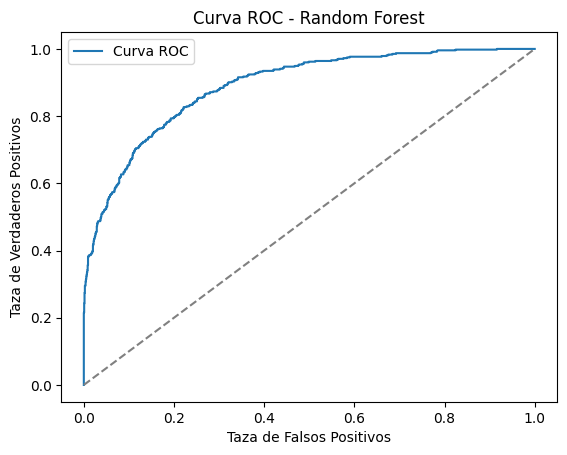

In [ ]:
# Obtenemos el mejor modelo encontrado por GridSearchCV().
mejor_modelo_rf = grid_rf.best_estimator_

# Hacemos predicciones con los datos de validación.
pred_proba = mejor_modelo_rf.predict_proba(features_valid)[:, 1]

# Mostramos el resultado de la métrica AUC-ROC.
print("AUC-ROC:", roc_auc_score(target_valid, pred_proba))

# Mostramos la curva ROC.
fpr, tpr, _ = roc_curve(target_valid, pred_proba)
plt.plot(fpr, tpr, label="Curva ROC")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taza de Falsos Positivos")
plt.ylabel("Taza de Verdaderos Positivos")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.show()

Hemos alcanzado un resultado de AUC-ROC mayor que 0.88. Lo que demuestra que nuestro modelo de clasificación binaria es bueno y puede clasificar correctamente las clases en la mayoría de los casos.

# Conclusiones

Hemos determinado que el bosque aleatorio es el mejor modelo de clasificación binaria al haber alcanzado la mayor calificación de AUC-ROC. Este modelo le será de muchas utilidad a nuestro cliente y mi recomendación es que se integre a un sistema de retnción automatizada.